<a href="https://colab.research.google.com/github/mateopolancecofficial/WineReviews/blob/main/SequenceTextModelWithPretrainedEmbeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
pip install -q -U tensorflow-text

     |████████████████████████████████| 3.4MB 11.5MB/s 


In [5]:
pip install -q -U tf-models-official

     |████████████████████████████████| 1.1MB 11.1MB/s 
     |████████████████████████████████| 645kB 27.8MB/s 
     |████████████████████████████████| 358kB 41.9MB/s 
     |████████████████████████████████| 706kB 40.6MB/s 
     |████████████████████████████████| 1.2MB 41.5MB/s 
     |████████████████████████████████| 37.6MB 77kB/s 
     |████████████████████████████████| 51kB 5.5MB/s 
     |████████████████████████████████| 102kB 9.8MB/s 
     |████████████████████████████████| 174kB 42.4MB/s 


In [6]:
pip install -q -U keras-tuner

     |████████████████████████████████| 71kB 5.1MB/s 


In [7]:
!git clone -l -s https://github.com/mateopolancecofficial/WineReviews.git

Cloning into 'WineReviews'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 3 (delta 0), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (3/3), done.


In [8]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import tensorflow_text as text
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras.layers import (
    Dense,
    Dropout,
)
import kerastuner as kt
from official.nlp import optimization
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

tf.get_logger().setLevel('ERROR')
os.environ["TFHUB_MODEL_LOAD_FORMAT"]="UNCOMPRESSED"

In [9]:
import os

if tf.test.is_gpu_available():
  strategy = tf.distribute.MirroredStrategy()
  print('Using GPU')

Using GPU


In [10]:
# set parameters
AUTOTUNE = tf.data.AUTOTUNE
path_v1 = "/content/WineReviews/Data/winemag-data-130k-v2.csv" 
path_v2 = "/content/WineReviews/Data/winemag-data_first150k.csv"
checkpoint_path = "/content/WineReviews/checkpoints/cp-{epoch:04d}.ckpt"
save_model_path = '/content/WineReviews/SavedModels/SequenceModelWeights.h5'
batch_size = 1024
seed = 42
col_idx = 0
train_size, test_size, val_size = 0.8, 0.2, 0.2
transform = 'normalize'
columns = ['description', 'points']

In [11]:
def load_data(path_v1: str, path_v2: str, columns: list, col_idx: int):
  """
  Load and concatenate two datasets with removing duplicates.
  param path_v1: import path of first dataset
  param path_v2: import path of second dataset
  param columns: list of columns to preserve in dataframe
  param col_idx: index of column given in input columns list 
                 on which look for duplicates in dataframe
  return:        pandas dataframe
  """
  
  df_v1 = pd.read_csv(path_v1, index_col=0)
  df_v1 = df_v1[columns]
  # remove numbers form column description from first dataframe
  df_v1.description = df_v1.description.str.replace('\d+', '')

  df_v2 = pd.read_csv(path_v2, index_col=0)
  df_v2 = df_v2[columns]
  # remove numbers form column description from second dataframe
  df_v2.description = df_v2.description.str.replace('\d+', '')

  df = pd.concat([df_v1, df_v2])

  # dropping duplicte values
  df.drop_duplicates(subset = columns[col_idx],
                       keep = 'first', inplace = True)
  
  return df

In [12]:
def split_data(df: pd.DataFrame, train_size: float, test_size: float, 
               val_size: float):
  """
  Split dataset on train, test and validation subsets.
  param df:          input dataframe
  param train_size:  fraction of train size
  param test_size:   fraction of test size
  param val_size:    fraction of validation size
  return:            dictionary, keys=names of dataframes, columns=dataframes
  """
  
  # shuffle dataset
  df = df.sample(frac = 1)
  
  # split on test and train set
  text_train, text_test, y_train, y_test = train_test_split(df.description, df.points,
                                           test_size=test_size, train_size=train_size)
  
  y_train, y_test = y_train.astype('float'), y_test.astype('float')
  
  # split train set on train and validation subsets
  text_train, text_val, y_train, y_val = train_test_split(text_train, y_train,
                                                  test_size=val_size, train_size=train_size)
  
  y_train, y_val = y_train.astype('float'), y_val.astype('float')

  y_train = y_train.to_numpy().reshape(-1, 1)
  y_val = y_val.to_numpy().reshape(-1, 1)
  y_test = y_test.to_numpy().reshape(-1, 1)

  # apply target variable transformation
  if transform == 'normalize':
    scaler = MinMaxScaler()
    scaler.fit(y_train)
    y_train = scaler.transform(y_train)
    y_val = scaler.transform(y_val)
    y_test = scaler.transform(y_test)
    
  elif transform == 'standardize':
    scaler = StandardScaler()
    scaler.fit(y_train)
    y_train = scaler.transform(y_train)
    y_val = scaler.transform(y_val)
    y_test = scaler.transform(y_test)
    
  else:
    scaler = MinMaxScaler()
    scaler.fit(y_train)
    y_train = scaler.transform(y_train)
    y_val = scaler.transform(y_val)
    y_test = scaler.transform(y_test)
  
  y_train, y_val, y_test = y_train.ravel(), y_val.ravel(), y_test.ravel()

  dataset_dict = {
      'text_train': text_train,
      'y_train': y_train,
      'text_val': text_val,
      'y_val': y_val,
      'text_test': text_test,
      'y_test': y_test,
      'scaler': scaler
  }

  return dataset_dict

In [13]:
def create_input_datasets(df_data: dict):
  """
  Create tensorflow datasets based on input dataframes for train, validation 
  and test subsets.
  param df_data: dictionary, keys=names of dataframes, columns=dataframes
  return:        dictionary, keys=names of datasets, columns=datasets
  """

  # create train dataset for input in tensorflow model
  train_dataset = tf.data.Dataset.from_tensor_slices((df_data['text_train'], 
                                                      df_data['y_train']))
  train_dataset = train_dataset.batch(batch_size)
  train_ds = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)

  # create validation dataset for input in tensorflow model
  val_dataset = tf.data.Dataset.from_tensor_slices((df_data['text_val'], 
                                                    df_data['y_val']))
  val_dataset = val_dataset.batch(batch_size)
  val_ds = val_dataset.cache().prefetch(buffer_size=AUTOTUNE)

  # create validation dataset for input in tensorflow model
  test_dataset = tf.data.Dataset.from_tensor_slices((df_data['text_test'], 
                                                     df_data['y_test']))
  test_dataset = test_dataset.batch(batch_size)
  test_ds = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)

  datasets = {
      'train_dataset': train_dataset,
      'val_dataset': val_dataset,
      'test_dataset': test_dataset
  } 

  return datasets

In [14]:
# define loss functions
from tensorflow.keras import backend as K

def rmse():
  def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 
  return root_mean_squared_error

def rmsle():
  def root_mean_squared_log_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(K.log(1+y_pred) - K.log(1+y_true))))
  return root_mean_squared_log_error

In [15]:
# disable eager execution
tf.config.run_functions_eagerly(False)

def model_builder(hp):
  # use pretrained embeddings for input layer
  hub_model = "https://tfhub.dev/google/nnlm-en-dim128-with-normalization/2"
  # 'trainable=True' - boolean controlling whether this layer is trainable
  hub_layer = hub.KerasLayer(hub_model, input_shape=[], dtype=tf.string, 
                             trainable=True)
  model = tf.keras.Sequential()
  model.add(hub_layer)
  hp_units_1 = hp.Int('units_1', min_value=64, max_value=128, step=16)
  activation=hp.Choice(
        'dense_activation',
        values=['relu', 'tanh', 'sigmoid'],
        default='relu'
    )
  model.add(Dense(units=hp_units_1, activation=activation))
  model.add(
            Dropout(rate=hp.Float(
                'dropout_1',
                min_value=0.1,
                max_value=0.5,
                default=0.25,
                step=0.1,
            ))
        )
  hp_units_2 = hp.Int('units_2', min_value=8, max_value=64, step=16)
  model.add(Dense(units=hp_units_2, activation=activation))
  model.add(
            Dropout(rate=hp.Float(
                'dropout_2',
                min_value=0.1,
                max_value=0.5,
                default=0.25,
                step=0.1,
            ))
        )
  model.add(Dense(1))

  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
  
  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
              loss=rmse(),
              metrics=['mean_absolute_error'])

  return model


In [17]:
# call data transformation functions
df = load_data(path_v1, path_v2, columns, col_idx)
df_data = split_data(df, train_size, test_size, val_size)
datasets = create_input_datasets(df_data)

In [18]:
# define early stop callback to prevent overfitting
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15)

In [19]:
tuner = kt.Hyperband(model_builder,
                     objective='mean_absolute_error',
                     max_epochs=5,
                     directory='SequenceTextPretrained'
                    )
                    

In [20]:
tuner.search(df_data['text_train'], df_data['y_train'], 
             validation_data=(df_data['text_val'], df_data['y_val']), 
             epochs=5, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

Trial 10 Complete [00h 31m 32s]
mean_absolute_error: 0.06893298774957657

Best mean_absolute_error So Far: 0.06122862547636032
Total elapsed time: 03h 16m 08s


In [21]:
model = tuner.hypermodel.build(best_hps)

In [22]:
# checkpoints callback is not defined because a lack of disk space on Google Colab
history = model.fit(datasets['train_dataset'],
                    validation_data=datasets['val_dataset'],
                    epochs=100,
                    callbacks=[stop_early]
                    )

Epoch 1/100
106/106 [==============================] - 14s 124ms/step - loss: 0.4300 - mean_absolute_error: 0.3539 - val_loss: 0.1459 - val_mean_absolute_error: 0.1170
Epoch 2/100
106/106 [==============================] - 14s 128ms/step - loss: 0.1971 - mean_absolute_error: 0.1571 - val_loss: 0.1118 - val_mean_absolute_error: 0.0888
Epoch 3/100
106/106 [==============================] - 13s 126ms/step - loss: 0.1430 - mean_absolute_error: 0.1135 - val_loss: 0.0972 - val_mean_absolute_error: 0.0770
Epoch 4/100
106/106 [==============================] - 13s 127ms/step - loss: 0.1238 - mean_absolute_error: 0.0978 - val_loss: 0.0943 - val_mean_absolute_error: 0.0746
Epoch 5/100
106/106 [==============================] - 13s 127ms/step - loss: 0.1142 - mean_absolute_error: 0.0902 - val_loss: 0.0929 - val_mean_absolute_error: 0.0734
Epoch 6/100
106/106 [==============================] - 14s 128ms/step - loss: 0.1072 - mean_absolute_error: 0.0847 - val_loss: 0.0916 - val_mean_absolute_error:

In [23]:
from sklearn.metrics import mean_absolute_error

eval_result = model.predict(df_data['text_test'])
y_real = df_data['scaler'].inverse_transform(df_data['y_test'].reshape(-1, 1))
y_predict = df_data['scaler'].inverse_transform(eval_result.reshape(-1, 1))

mean_absolute_error(y_real, y_predict)

1.3786372378550311

In [24]:
from sklearn.metrics import r2_score

r2_score(y_real, y_predict)

0.6840138763299649

In [25]:
import matplotlib.pyplot as plt

def plot():
  """
  Plot training and validation loss and mean absolute error metric. 
  """

  acc = history.history['mean_absolute_error']
  val_acc = history.history['val_mean_absolute_error']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(1, len(acc) + 1)

  plt.plot(epochs, acc, 'bo', label='Training acc')
  plt.plot(epochs, val_acc, 'b', label='Validation acc')
  plt.title('Training and validation mean absolute error metric')
  plt.legend()
  plt.figure()
  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()

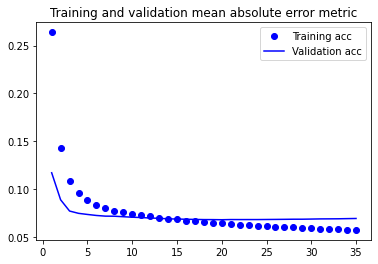

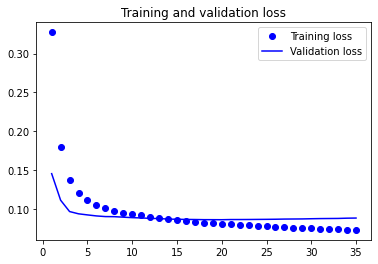

In [26]:
plot()

In [27]:
model.save(save_model_path)